<a href="https://colab.research.google.com/github/YuhaiW/00/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision 
import torchvision.datasets as datasets
import torchvision.transforms as transforms 
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter 
from torch.nn.modules.activation import LeakyReLU
from torch.nn.modules.conv import ConvTranspose2d


In [62]:

class Discriminator(nn.Module):
  def __init__(self, channel_img, features_d):
    super(Discriminator, self).__init__()
    # input = N * channel_img * 64 * 64
    self.disc = nn.Sequential(
        nn.Conv2d(
            channel_img,
            features_d,
            kernel_size = 4,
            stride = 2,
            padding = 1
        ), # 32 * 32
        nn.LeakyReLU(0.2),
        self._block(features_d, features_d*2, 4, 2, 1),  # 16 *16
        self._block(features_d*2, features_d*4, 4, 2, 1), # 8 * 8
        self._block(features_d*4, features_d*8, 4, 2, 1), # 4 * 4
        nn.Conv2d(features_d*8, 1, 4, 2, 0),  #1 * 1
        nn.Sigmoid(),
    )





  def _block(self, in_channel, out_channel, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels = in_channel, 
                  out_channels = out_channel, 
                  kernel_size = kernel_size,
                  stride = stride,
                  padding = padding,
                  bias = False), # cause we will use "BatchNorm2d", so the bias = False
        nn.BatchNorm2d(num_features = out_channel),
        nn.LeakyReLU(0.2),
    )

  def forward(self, x):
    return self.disc(x)

In [63]:

class Generator(nn.Module):
  def __init__(self, z_dim, channels_img, feature_g):
    super(Generator, self).__init__()
    self.gen = nn.Sequential(
        # 1 x 1
    self._block(z_dim, feature_g*16, 4, 1, 0), # 4x4
    self._block(feature_g*16, feature_g*8, 4, 2, 1), # 8x8
    self._block(feature_g*8, feature_g*4, 4, 2, 1), # 16x16
    self._block(feature_g*4, feature_g*2, 4, 2, 1), # 32x32
    nn.ConvTranspose2d(feature_g*2, channels_img, 4, 2, 1), # 64 * 64
    nn.Tanh(), #[-1,1]
    )


  def _block(self, in_channel, out_channel, kernel_size, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels = in_channel, 
                  out_channels = out_channel, 
                  kernel_size = kernel_size,
                  stride = stride,
                  padding = padding,
                  bias = False), # cause we will use "BatchNorm2d", so the bias = False
        nn.BatchNorm2d(num_features = out_channel),
        nn.LeakyReLU(0.2),
    )
  
  def forward(self, x):
    return self.gen(x)

In [64]:
def initialize_weight(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data, 0.0, 0.02)
      

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [66]:
LEARNING_RATE = 2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1
FEATURES_DISC = 64
FEATURES_GEN = 64
Z_DIM = 100
EPOCH_NUM = 5

In [67]:
transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
     
    ]
)
dataset = datasets.MNIST(root = "dataset/", train = True, transform = transforms,
                        download = True)

loader = DataLoader(dataset = dataset,
                    batch_size = BATCH_SIZE,
                    shuffle = True)



In [68]:
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weight(gen)
initialize_weight(disc)
opt_gen = optim.Adam(gen.parameters(), lr = LEARNING_RATE, betas = (0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr = LEARNING_RATE, betas = (0.5, 0.999))
criterion = nn.BCELoss()

In [69]:
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
step = 0
gen.train()
disc.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

In [78]:
for epoch in range(EPOCH_NUM):
  for batch_idx, (real, _) in enumerate(loader):
    real = real.to(device)
    noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device)
    fake  = gen(noise)
    ## Train Discriminator
    disc_real = disc(real).reshape(-1)
    loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
    disc_fake = disc(fake).reshape(-1)
    loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
    disc_loss = (loss_disc_real+loss_disc_fake)/2
    disc.zero_grad()
    disc_loss.backward(retain_graph = True) # we need to reuse the "fake" image
    opt_disc.step()

    ## Train Generator
    
    gen_disc_fake = disc(fake).reshape(-1)
    gen_loss = criterion(gen_disc_fake, torch.ones_like(gen_disc_fake))
    gen.zero_grad()
    gen_loss.backward()
    opt_gen.step()

    if batch_idx % 100 == 0:
      print(f"The No.[{epoch}/{EPOCH_NUM} epoch, Batch: {batch_idx}/{len(loader)}\
      Loss_Disc = {disc_loss:.4f}\
      Loss_Gen = {gen_loss:.4f}")






The No.[0/5 epoch, Batch: 0/469      Loss_Disc = 0.6851      Loss_Gen = 0.8012
The No.[0/5 epoch, Batch: 100/469      Loss_Disc = 0.0155      Loss_Gen = 4.0720
The No.[0/5 epoch, Batch: 200/469      Loss_Disc = 0.8719      Loss_Gen = 0.4942
The No.[0/5 epoch, Batch: 300/469      Loss_Disc = 0.5695      Loss_Gen = 1.1250
The No.[0/5 epoch, Batch: 400/469      Loss_Disc = 0.6140      Loss_Gen = 0.9166
The No.[1/5 epoch, Batch: 0/469      Loss_Disc = 0.6827      Loss_Gen = 0.8263
The No.[1/5 epoch, Batch: 100/469      Loss_Disc = 0.6120      Loss_Gen = 0.8171
The No.[1/5 epoch, Batch: 200/469      Loss_Disc = 0.5516      Loss_Gen = 0.8888
The No.[1/5 epoch, Batch: 300/469      Loss_Disc = 0.6297      Loss_Gen = 0.7463
The No.[1/5 epoch, Batch: 400/469      Loss_Disc = 0.4646      Loss_Gen = 1.1895
The No.[2/5 epoch, Batch: 0/469      Loss_Disc = 0.5041      Loss_Gen = 2.0899
The No.[2/5 epoch, Batch: 100/469      Loss_Disc = 0.4825      Loss_Gen = 1.0166
The No.[2/5 epoch, Batch: 200/469 

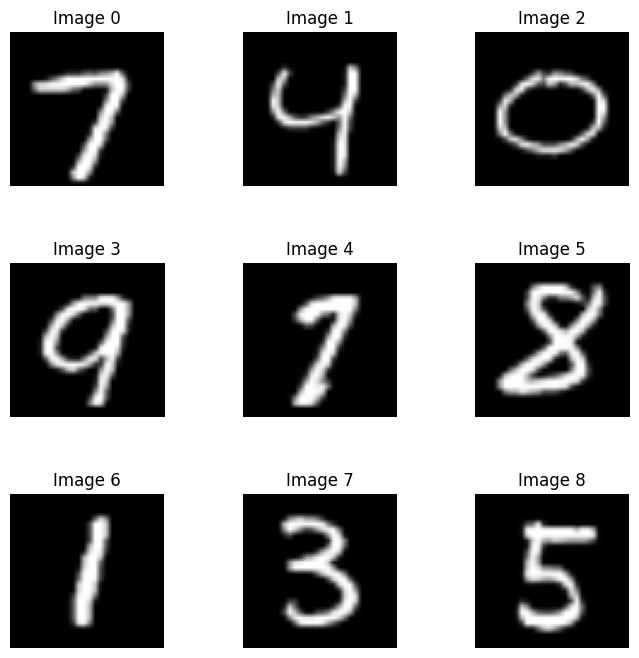

In [81]:
import matplotlib.pyplot as plt
import numpy as np

# Assume you have a tensor with shape (9, 28, 28)
# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Loop over the tensor and plot each image in a subplot
for i in range(9):
    # Get the i-th image
    img = real[i].cpu().detach().numpy().reshape(64,64)

    # Plot the image in the corresponding subplot
    ax = axs[i // 3, i % 3]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Image {i}")
    ax.axis('off')

# Show the plot
plt.show()

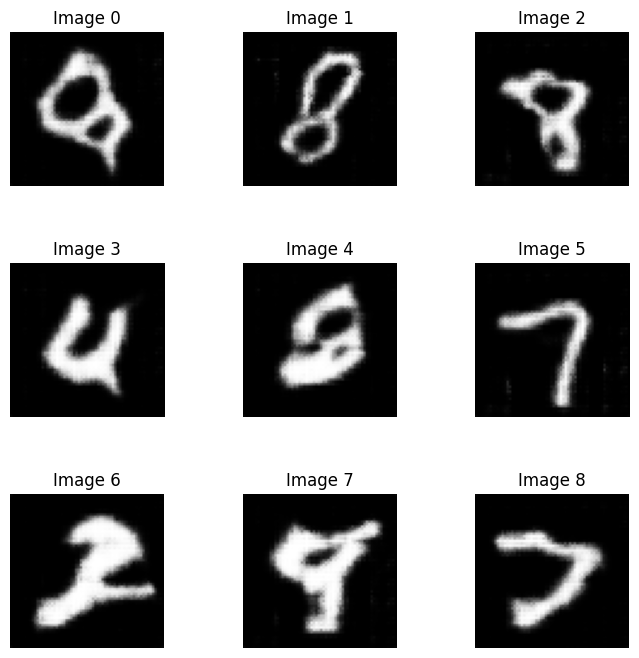

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Assume you have a tensor with shape (9, 28, 28)
# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Loop over the tensor and plot each image in a subplot
for i in range(9):
    # Get the i-th image
    img = fake[i].cpu().detach().numpy().reshape(64,64)

    # Plot the image in the corresponding subplot
    ax = axs[i // 3, i % 3]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Image {i}")
    ax.axis('off')

# Show the plot
plt.show()
     